# Data Scraping and Processing

In [ ]:
pip install requests_html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 6.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=ed7be134ee1de7bacfcbc099a3fcc21af43d7de9e6466d6f70ae0dcf776a77a2
  Stored in directory: /root/.cache/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=4a1cd2512320a18ea921826349fb2aaf7ab94b4e4a0406bfc0e6c19b62d15ea5
  Stored in directory: /root/.cache/pip/wheels/d6/9c/58/ee3ba36897e890f3ad81e9b730791a153fce20caa4a8a474df
Successfully built bs4 parse


In [ ]:
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('brown')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from string import punctuation
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_source(url):
    try:
        session = HTMLSession()
        response = session.get(url)
        return response
    except requests.exceptions.RequestException as e:
        print(e)

def scrape(q):
    q = urllib.parse.quote_plus(q)
    result = get_source("https://www.google.com/search?q=" + q)
    lst = list(result.html.absolute_links)
    exclude_domains = ('google', 'https://google.', 'https://webcache.googleusercontent.', 'http://webcache.googleusercontent.', 'https://policies.google.',
                       'https://support.google.','https://maps.google.','https://www.instagram.','https://www.youtube.', 'facebook', 'tripadvisor')
    links = lst.copy()
    for url in lst:
        for domain in exclude_domains:
            if domain in url:
                try:
                  links.remove(url)
                except:
                  continue
                continue

    return links

def filter_text(txt):
    stop_words = ["inbox","©",":","=","@", "copyright", "cookies","..","\xa0","min","redirecting…","seconds…", "#", '()', "captcha",'redirect','anti-virus','malware','JavaScript','developer','technology','subscribe','learn more…','support us', 'articles', 'article', 'content', 'blog', '.com']
    if not txt or len(txt)<30:
        return False
    for x in stop_words:
        if x in txt.lower():
            return False
    return True

def get_text(links):
    result = []
    for url in links:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        # soup = str(soup.find_all('div')).split('>')
        # main = url.split('/')
        # text = list(set(filter(lambda x:"<br" in x or "</p" in x, soup)))
        # text = list(filter(lambda x:filter_text(x), text))
        p = set(map(lambda x : x.get_text(), soup.find_all('p')))
        text = list(filter(lambda x:filter_text(x), p))
        result.extend(text)
    df = pd.DataFrame(result, columns = ['Content'])
    return df

def process_text(text):
    # remove '\n' present in the raw reviews
    text = text.replace('\n', ' ')
    # lower text
    text = text.lower()
    # split sentence into words
    token = word_tokenize(text)
    # spelling error check
    # token = [checker(x) for x in token]
    # remove punctuation
    table = str.maketrans('', '', punctuation)
    stripped = [x.translate(table) for x in token]
    # remove remaining tokens that are not alphabetic
    word = [x for x in stripped if x.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    word = [x for x in word if not x in stop_words]
    # lemmatization
    lemmatized_output = [lemmatizer.lemmatize(x) for x in word]
    # join all words into one sentence
    result = " ".join(lemmatized_output)
    return result

def clean_text(df):
    df['review_splitted'] = df['Content'].apply(sent_tokenize)
    df['cleaned'] = df['review_splitted'].apply(lambda reviews: [process_text(sentence) for sentence in reviews])
    # clean the full text
    df['cleaned_text'] = df['Content'].apply(lambda review: process_text(review))
    return df

def run(name):
    links = scrape(name + " condominium review")
    df = get_text(links)
    df = clean_text(df)
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = run("Wallich Residence")

In [ ]:
df['cleaned_text']

0      wallich residence located right tanjong pagar ...
1      definitely not private residential project any...
2      despite launching start downtrending property ...
3      one exciting plan ahead location wallich resid...
4      good news wallich residence showflat actual un...
                             ...                        
434    druce chief editor stacked editorial first int...
435       kitchen area small wooden island area attached
436    one first thing catch attention switch definit...
437    taking close look unit mix wallich residence o...
438    closer look kitchen lot storage space particul...
Name: cleaned_text, Length: 439, dtype: object

# Data Exploratory

In [ ]:
def toInteger(x):
  return int(float(x))

df_total["Rating"] = df_total["Rating"].apply(lambda x : toInteger(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_positive = df_total[df_total["Rating"]>=4]
df_negative = df_total[df_total["Rating"]<4]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_ratings = pd.concat([df_positive, df_negative])
df_ratings["Rating"].value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    945
4    738
0    402
3    360
1    312
2    210
Name: Rating, dtype: int64

In [ ]:
from textblob import TextBlob

def is_positive_blob(sentence):
  return TextBlob(sentence).polarity

df_ratings["Polarity"] = 0
df_ratings["Polarity"] = df_ratings["Content"].apply(lambda x: TextBlob(x).sentiment.polarity) # Polarity score in review level

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_ratings.head(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,Name,Rating,Date,Content,score,sentiment,review_splitted,cleaned,cleaned_text,Polarity
2,2.0,The Glades,4.2,"Posted on March 16, 2023 by",Love the greens and the swimming pool is a plu...,0.6315,Positive,[Love the greens and the swimming pool is a pl...,[love green swimming pool plusmy unit high ris...,love green swimming pool plusmy unit high rise...,0.067083
3,3.0,Tanamera Crest,4.7,"Posted on March 16, 2023 by free wififr",5 mins walk to 85 Market with famous hawker st...,-0.2023,Negative,[5 mins walk to 85 Market with famous hawker s...,[min walk market famous hawker stall round clo...,min walk market famous hawker stall round cloc...,0.153333
5,5.0,Kellock Lodge,4.0,"Posted on March 15, 2023 by Julia Cai",Really enjoy the convenience and easy access t...,0.8400,Positive,[Really enjoy the convenience and easy access ...,[really enjoy convenience easy access gwc mrt ...,really enjoy convenience easy access gwc mrt b...,0.463810
8,8.0,Cape Royale,5.0,"Posted on March 13, 2023 by",fantastic sea view! Quiet and therapeutic. No ...,0.3632,Positive,"[fantastic sea view!, Quiet and therapeutic., ...","[fantastic sea view, quiet therapeutic, noisy ...",fantastic sea view quiet therapeutic noisy kid...,0.250000
9,9.0,The Shore Residences,5.0,"Posted on March 13, 2023 by",I have stayed here for the past 2 years and I ...,0.5849,Positive,[I have stayed here for the past 2 years and I...,[stayed past year must say condo well maintain...,stayed past year must say condo well maintaine...,-0.025000


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Polarity', ylabel='Density'>

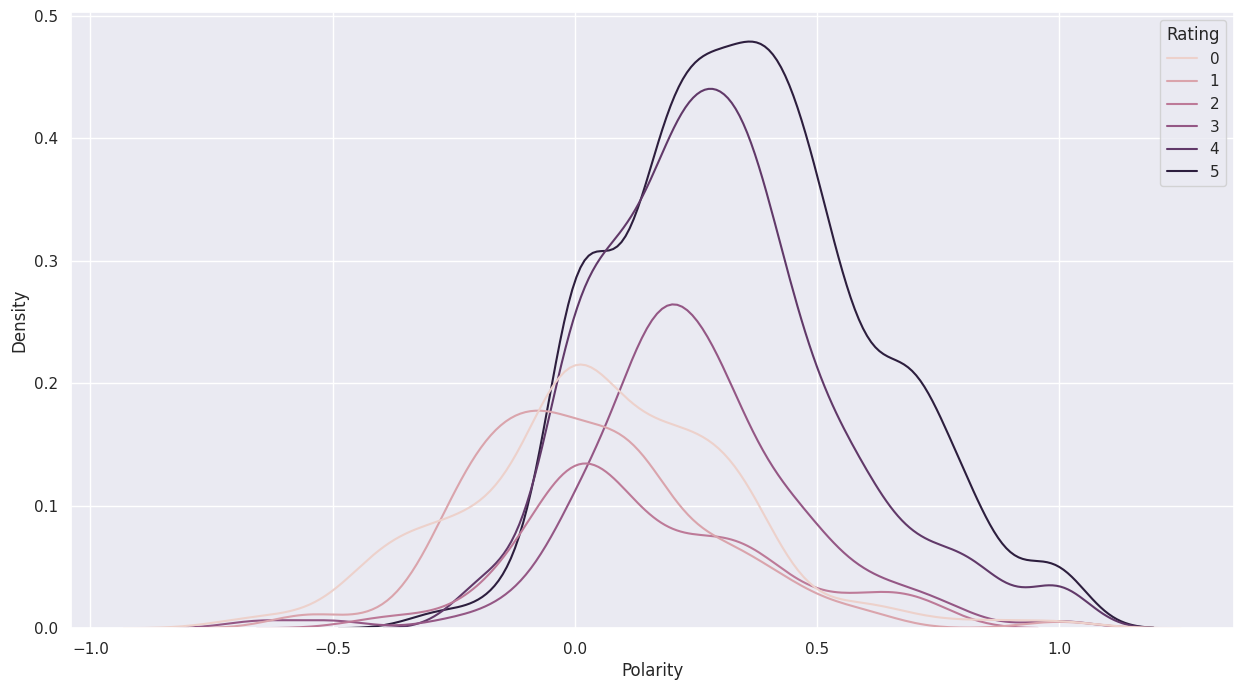

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.color_palette("tab10")
sns.kdeplot(data=df_ratings, x="Polarity", hue='Rating')

# Sentiment Analyzer

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.0 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline, AutoTokenizer
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import AutoConfig

def sentiment_analysis(sentence):
  
    finetuned_model = "potatobunny/results-yelp"  # from huggingface repo
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', config=AutoConfig.from_pretrained(finetuned_model), padding=True, truncation=True)
    model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = classifier(sentence)
    return results

def get_sentiment(df):
    map_label = {'LABEL_1': 1, 'LABEL_0': 0}

    sentences = df['cleaned'].drop_duplicates().dropna().to_list()
    full_sentence = []
    for x in sentences:
        full_sentence.extend(x)

    whole_sentences = df['review_splitted'].drop_duplicates().dropna().to_list()
    full_whole_sentence = []
    for x in whole_sentences:
      full_whole_sentence.extend(x)

    full_sentence = [x for x in full_sentence if (x != '')]
    full_whole_sentence = [x for x in full_whole_sentence if (x != '')]
    res = sentiment_analysis(full_sentence)
    final = {}
    for x in range(len(full_sentence)):
      final[full_sentence[x]] = [map_label[res[x]['label']], full_whole_sentence[x], res[x]['score']] # final format
    return final

In [ ]:
df_sentiment = get_sentiment(df_content[:100])

In [ ]:
df_sentiment = pd.DataFrame(df_sentiment).T

In [ ]:
df_sentiment.head(5)

,0,1,2
kid studying bukit timah area property far enough madding crowd yet stone throw eatery neighbourhood mall beautiful hil wak,1,"With a kid studying in the Bukit Timah area, t...",0.999649
terrible condo unimpressive entrance,0,Terrible condo with a very unimpressive entrance.,0.99968
lot noise road,0,Lots of noise from the road.,0.999616
not expect much peace quiet,1,Do not expect much peace and quiet here.,0.997934
traffic abysmal well,1,Traffic is abysmal as well.,0.996949


# Topic Model


In [ ]:
import nltk; nltk.download('stopwords')

import pandas as pd
import numpy as np

import re
import string

!pip install spacy
import spacy

!pip install gensim
import gensim
from gensim import corpora

# libraries for visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 24.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
df = pd.read_csv("reviews.csv")
df2 = pd.read_csv("review_property_guru_2.csv")
df3 = pd.read_csv("review_property_guru_3.csv")
df_total = pd.concat([df, df2, df3])
df_content = clean_text(df_total)
print(len(df_content))
df_content.head(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2967


,Unnamed: 0,Name,Rating,Date,Content,score,sentiment,review_splitted,cleaned,cleaned_text
0,0.0,Southaven I,0.0,"Posted on March 17, 2023 by Quek Tseng","With a kid studying in the Bukit Timah area, t...",0.5994,Positive,"[With a kid studying in the Bukit Timah area, ...",[kid studying bukit timah area property far en...,kid studying bukit timah area property far eno...
1,1.0,Viz at Holland,0.0,"Posted on March 17, 2023 by Jason Yuan",Terrible condo with a very unimpressive entran...,-0.7610,Negative,[Terrible condo with a very unimpressive entra...,"[terrible condo unimpressive entrance, lot noi...",terrible condo unimpressive entrance lot noise...
2,2.0,The Glades,4.2,"Posted on March 16, 2023 by",Love the greens and the swimming pool is a plu...,0.6315,Positive,[Love the greens and the swimming pool is a pl...,[love green swimming pool plusmy unit high ris...,love green swimming pool plusmy unit high rise...
3,3.0,Tanamera Crest,4.7,"Posted on March 16, 2023 by free wififr",5 mins walk to 85 Market with famous hawker st...,-0.2023,Negative,[5 mins walk to 85 Market with famous hawker s...,[min walk market famous hawker stall round clo...,min walk market famous hawker stall round cloc...
4,4.0,H2O Residences,3.8,"Posted on March 16, 2023 by Lim Ming",Been living in the condo since 2016 and boy am...,-0.8020,Negative,[Been living in the condo since 2016 and boy a...,[living condo since boy suprised negative revi...,living condo since boy suprised negative revie...


In [ ]:
lstOfShorts = []
for i in df_total["cleaned"]:
  for j in i:
    lstOfShorts.append(j)

len(lstOfShorts)

short_review_df = pd.DataFrame(lstOfShorts)
short_review_df.to_csv('short_manual_review.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def getRating(x):
  return x[8:]

df2["Rating"] = df2["Rating"].apply(lambda x : getRating(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df3["Rating"] = df3["Rating"].apply(lambda x : getRating(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_total = pd.concat([df, df2, df3])
df_content = clean_text(df_total)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc = True removes punctuations

data_words = list(sent_to_words(df_content['cleaned_text']))

print(data_words)

[['kid', 'studying', 'bukit', 'timah', 'area', 'property', 'far', 'enough', 'madding', 'crowd', 'yet', 'stone', 'throw', 'eatery', 'neighbourhood', 'mall', 'beautiful', 'hil', 'wak'], ['terrible', 'condo', 'unimpressive', 'entrance', 'lot', 'noise', 'road', 'not', 'expect', 'much', 'peace', 'quiet', 'traffic', 'abysmal', 'well', 'property', 'nt', 'tall'], ['love', 'green', 'swimming', 'pool', 'plusmy', 'unit', 'high', 'rise', 'not', 'facing', 'mrtthe', 'noise', 'not', 'bother', 'especially', 'door', 'closed', 'hardly'], ['min', 'walk', 'market', 'famous', 'hawker', 'stall', 'round', 'clock', 'min', 'doortodoor', 'anglican', 'high', 'school', 'food', 'factory', 'stone', 'throw', 'min', 'walk', 'away', 'buy', 'freshest'], ['living', 'condo', 'since', 'boy', 'suprised', 'negative', 'review', 'bad', 'review', 'disgruntled', 'exresidents', 'cant', 'get', 'way', 'council'], ['really', 'enjoy', 'convenience', 'easy', 'access', 'gwc', 'mrt', 'bus', 'mall', 'grocery', 'eating', 'place', 'neighb

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define functions for stopwords, bigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

print(data_lemmatized[:1])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['kid', 'study', 'area', 'property', 'enough', 'madding', 'crowd', 'eatery', 'neighbourhood', 'mall', 'beautiful', 'hil', 'wak']]


In [ ]:
len(data_lemmatized)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2967

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View

# Gensim maps each word into unique id, that means (word_id, word_frequency)
print(corpus[:1])

# To access word, call the dictionary
id2word[300]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'furnish'

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.14899680139653393),
 (1, 0.18757338465757292),
 (2, 0.26154544279112013),
 (3, 0.2556816828009017),
 (4, 0.30667715201843065),
 (5, 0.3838303185405087),
 (6, 0.1945392449262074),
 (7, 0.3838303185405087),
 (8, 0.19271435208133716),
 (9, 0.2331158281872464),
 (10, 0.19837899112438787),
 (11, 0.32268788066581444),
 (12, 0.3838303185405087)]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=20,iterations=30)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


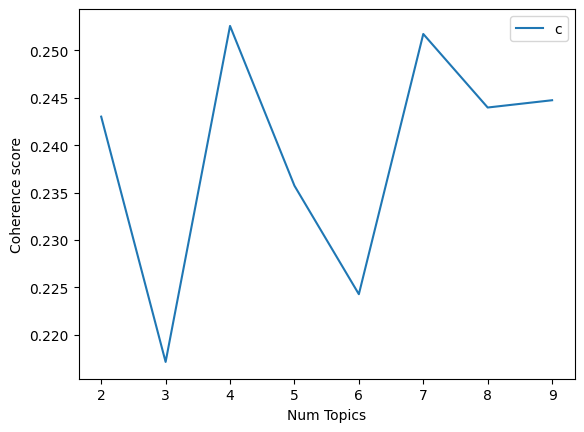

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_model_tfidf0 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=id2word, passes=20, workers=10)
topics = []
for idx, topic in lda_model_tfidf0.print_topics(-1):
    pprint('Topic: {} Word: {}'.format(idx, topic))
    topics.append(topic)
    print()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('Topic: 0 Word: 0.010*"condo" + 0.010*"amenity" + 0.008*"great" + '
 '0.007*"small" + 0.007*"nice" + 0.007*"well_maintaine" + 0.006*"development" '
 '+ 0.006*"peaceful" + 0.006*"area" + 0.005*"pool"')

('Topic: 1 Word: 0.021*"good" + 0.019*"location" + 0.010*"convenient" + '
 '0.008*"place" + 0.008*"great" + 0.007*"quiet" + 0.006*"park" + '
 '0.006*"family" + 0.006*"facility" + 0.006*"condo"')

('Topic: 2 Word: 0.009*"place" + 0.007*"unit" + 0.007*"many" + 0.007*"living" '
 '+ 0.006*"condo" + 0.005*"great" + 0.005*"quiet" + 0.005*"peaceful" + '
 '0.005*"location" + 0.005*"facility"')

('Topic: 3 Word: 0.013*"nice" + 0.008*"stay" + 0.007*"place" + 0.007*"unit" + '
 '0.007*"excellent" + 0.006*"facility" + 0.006*"good" + 0.006*"condo" + '
 '0.006*"live" + 0.005*"love"')



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, [('condo', 0.010435868), ('amenity', 0.010098761), ('great', 0.00834151), ('small', 0.0073659346), ('nice', 0.006920485), ('well_maintaine', 0.006555273), ('development', 0.0061904425), ('peaceful', 0.005874819), ('area', 0.00561823), ('pool', 0.0053693964)]), (1, [('good', 0.021364443), ('location', 0.018557612), ('convenient', 0.010431065), ('place', 0.008299022), ('great', 0.007904572), ('quiet', 0.007493436), ('park', 0.0063141338), ('family', 0.006164986), ('facility', 0.0060585565), ('condo', 0.005793649)]), (2, [('place', 0.008646688), ('unit', 0.007307076), ('many', 0.0066775354), ('living', 0.006501504), ('condo', 0.0056972317), ('great', 0.005413497), ('quiet', 0.005311568), ('peaceful', 0.0049764793), ('location', 0.004927701), ('facility', 0.0049050013)]), (3, [('nice', 0.01317754), ('stay', 0.008330365), ('place', 0.007352085), ('unit', 0.0071491175), ('excellent', 0.00709407), ('facility', 0.006484938), ('good', 0.0060723578), ('condo', 0.005976657), ('live', 0.00566

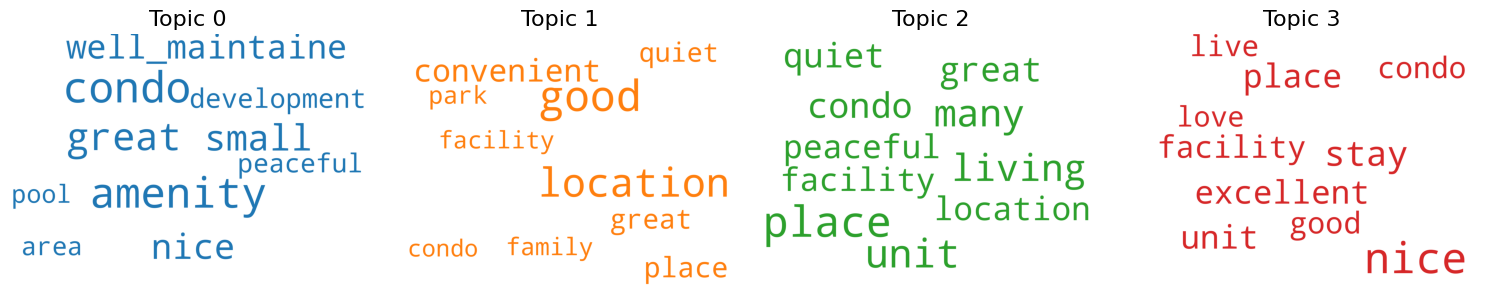

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf0.show_topics(formatted=False)
print(topics)

fig, axes = plt.subplots(1, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# BERT Topic

In [ ]:
import joblib

In [ ]:
model = joblib.load("topic_model.pkl")

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]
from bertopic import BERTopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=3582411 sha256=d8e33afe01f6621217c435c2056571e972e2c2406300973af0f7dfe81a04a5fe

In [ ]:
cleaned_text = []
for i in df_content["cleaned"][:1000]:
  cleaned_text.extend(i)
len(cleaned_text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2326

In [ ]:
model_bert = BERTopic(nr_topics=8) 
topics, probabilities = model_bert.fit_transform(cleaned_text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_bert.visualize_barchart()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
joblib.dump(model_bert, "model_bert_use.pkl")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['model_bert_use.pkl']

In [ ]:
model_bert_2 = BERTopic(nr_topics=8) 
topics, probabilities = model_bert_2.fit_transform(cleaned_text)
model_bert_2.visualize_barchart()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import joblib
filename = 'topic_model.pkl'
joblib.dump(lda_model_tfidf0, filename)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['topic_model.pkl']

In [ ]:
model = joblib.load('model_bert_new.pkl')

EOFError: ignored

In [ ]:
from transformers import pipeline, AutoTokenizer
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import AutoConfig
from bertopic import BERTopic
import joblib
from tqdm import tqdm
tqdm.pandas()

# load pre-trained model
model = joblib.load("model_bert_use.pkl")

def sentiment_analysis(sentence):
    '''
    Predict sentiment for each sentence

    Parameters
    ----------
    sentence: list of sentences to predict

    Results
    -------
    results: llist of dictionaries, result from the sentiment analysis model
    '''
    # fine tuned model from yelp dataset
    finetuned_model = "potatobunny/results-yelp"  # from huggingface repo
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', config=AutoConfig.from_pretrained(finetuned_model), padding=True, truncation=True)
    model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = classifier(sentence)
    return results

def get_sentiment(df):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from run_scrape

    Results
    -------
    final_df: DataFrame with 2 columns, Review: list of sentences that has been cleaned, Sentiment: the sentiment results for the list of sentences
    '''
    map_label = {'LABEL_1': 'Positive', 'LABEL_0': 'Negative'}

    reviews = df['cleaned'].drop_duplicates().dropna().to_list()
    sa_result = []
    for sentences in tqdm(reviews):
        # get sentiment for each sentences
        res = sentiment_analysis(sentences)
        sa_result.append(res)

    final_df = pd.DataFrame(pd.Series(reviews), columns = ['Review'])
    final_df['Sentiment'] = pd.Series(sa_result)

    # map label to 'Positive' and 'Negative'
    final_df['Sentiment Score'] = final_df['Sentiment'].progress_apply(lambda sa: [res['score'] for res in sa])
    final_df['Sentiment'] = final_df['Sentiment'].progress_apply(lambda sa: [map_label[label['label']] for label in sa])
    return final_df


def predict_topic(sentences, model):
    '''
    Get topic for each sentence

    Parameters
    ----------
    sentences: list of sentences
    model: pre-trained model

    Results
    -------
    lst_topics: list of topics corresponding to the sentences
    '''
    lst_topics = []
    for i in sentences:
        idx = model.find_topics(i, top_n = 1)[0][0]
        topics = ''
        if idx == 1:
            topics = "Environment"
        elif idx == 0:
            topics = "Location"
        elif idx == 2:
            topics = "Service and Management"
        elif (idx == 3) or (idx == 6):
            topics = "Facilities"
        elif (idx == 4) or (idx == 5):
            topics = "Financial Value"
        lst_topics.append(topics)
    return lst_topics

def get_topics(df, model):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from get_sentiment

    Results
    -------
    df: DataFrame appended with 1 column, list of topics from predict_topic
    '''
    df['Topics'] = df['Review'].progress_apply(lambda x: predict_topic(x, model))
    return df

def run_analysis(df):
    '''
    Get dataframe with sentiment and topics

    Parameters
    ----------
    df: DataFrame from run_scrape

    Results
    -------
    final_result: DataFrame with 3 columns, list of cleaned sentences, list of sentiment, and list of topics
    '''
    sa_result = get_sentiment(df)
    print('\nSentiment Analysis - done')
    final_result = get_topics(sa_result, model)
    print('\nTopic modelling - done')
    return final_result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
train_df_for_reg = pd.read_csv("df_srx_Condo.csv")
lst = train_df_for_reg["Property Name"].unique()
df = run(lst[1])
result = run_analysis(df)
result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 84/84 [00:00<00:00, 69711.42it/s]



Sentiment Analysis - done


100%|██████████| 84/84 [00:03<00:00, 24.99it/s]


Topic modelling - done


,Review,Sentiment,Sentiment Score,Topics
0,"[block total valley park contains total unit, ...","[Negative, Negative, Positive, Positive]","[0.9996200799942017, 0.9889416098594666, 0.614...","[Location, Service and Management, Facilities,..."
1,[perhaps main drawback project lack immediate ...,[Positive],[0.9996716976165771],[Location]
2,[word complete loop long road],[Negative],[0.9993667006492615],[Location]
3,[mentioned beginning review second entranceexi...,[Positive],[0.9592890739440918],[Location]
4,[carpark lot plentiful still prefer undergroun...,[Positive],[0.9996885061264038],[Location]
...,...,...,...,...
79,[debra l said love description star say woohoo...,"[Positive, Positive, Positive, Positive]","[0.9996852874755859, 0.9996713399887085, 0.999...","[Location, , Financial Value, Financial Value]"
80,[laura sacher compass real estate],[Positive],[0.998191773891449],[Financial Value]
81,[verify immediately update business informatio...,[Positive],[0.9975994229316711],[Location]
82,"[catherine said definitely service, know jinni...","[Positive, Positive, Positive, Positive, Posit...","[0.9996707439422607, 0.9996651411056519, 0.999...","[Location, Environment, Facilities, Facilities..."


In [ ]:
train_df_for_reg = pd.read_csv("df_srx_Condo.csv")
lst = train_df_for_reg["Property Name"].unique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
len(lst)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



483

In [ ]:
def get_final_score(result):
  index = {'Location': 0, 'Facilities': 1, 'Financial Value': 2, 'Service and Management': 3, 'Environment': 4}
  lstOfScore = [[], [], [], [], []]
  final_score = []
  for idx in range (len(result)):
    row = result.iloc[idx]
    for j in range (len(row['Topics'])):
      try:
        if (row['Sentiment'][j] == 'Positive'):
          lstOfScore[index[row['Topics'][j]]].append(row['Sentiment Score'][j])
        else:
          lstOfScore[index[row['Topics'][j]]].append(-1*row['Sentiment Score'][j])
      except:
        continue
  for x in lstOfScore:
    final_score.append(sum(x)/len(x))
  return final_score

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
get_final_score(result)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[0.618751398614935,
 0.6624451417189378,
 0.46979327587520375,
 0.6123388830353232,
 0.4556800172879146]

In [ ]:
lst = train_df_for_reg["Property Name"].unique()
for i in lst[20:25]:
  try:
    df = run(i)
    result = run_analysis(df)
    score.append(get_final_score(result))
  except:
    score.append([0])
    continue

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 27/27 [00:00<00:00, 30656.80it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:00<00:00, 33.00it/s]



Topic modelling - done


100%|██████████| 27/27 [00:00<00:00, 25802.28it/s]



Sentiment Analysis - done


100%|██████████| 27/27 [00:04<00:00,  6.57it/s]



Topic modelling - done


100%|██████████| 134/134 [00:00<00:00, 34112.45it/s]



Sentiment Analysis - done


100%|██████████| 134/134 [00:10<00:00, 12.98it/s]



Topic modelling - done


100%|██████████| 108/108 [00:00<00:00, 91604.62it/s]



Sentiment Analysis - done


100%|██████████| 108/108 [00:05<00:00, 21.44it/s]



Topic modelling - done


In [ ]:
score

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[0.2536166508992513,
  -0.9633444249629974,
  0.39602254033088685,
  0.9996893405914307,
  0.8216719925403595],
 [0.5870209244581369,
  0.6341412862141927,
  0.4370648954063654,
  0.6123388830353232,
  0.40656218528747556],
 [0.7108031511306763,
  0.1352273199869239,
  0.17722506685690445,
  -0.0004748106002807617,
  0.2521654475818981],
 [0],
 [0],
 [0.5870990987980005,
  0.2608463205397129,
  0.6960627182441599,
  0.9996772607167562,
  0.67320995926857],
 [0],
 [0.63095022873445,
  -0.13549906015396118,
  0.699927219704016,
  0.5996445775032043,
  0.7931333243846893],
 [0],
 [0.7799089742558343,
  0.42715903454356724,
  0.6642181006344882,
  0.5003813058137894,
  0.550549351506763],
 [0.3999355211853981,
  0.47115799188613894,
  0.6302785644928615,
  0.6162285644274491,
  0.6048580408096313],
 [0],
 [0.3910998839598436,
  0.11887019872665405,
  0.577266201376915,
  0.7949368178844451,
  0.6076414734125137],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0.5570405821005503,
  -0.9633444

In [ ]:
lst[0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'Simei Green Condominium'

In [ ]:
score

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[0.2536166508992513,
  -0.9633444249629974,
  0.39602254033088685,
  0.9996893405914307,
  0.8216719925403595],
 [0.5870209244581369,
  0.6341412862141927,
  0.4370648954063654,
  0.6123388830353232,
  0.40656218528747556],
 [0.7108031511306763,
  0.1352273199869239,
  0.17722506685690445,
  -0.0004748106002807617,
  0.2521654475818981],
 [0],
 [0],
 [0.5870990987980005,
  0.2608463205397129,
  0.6960627182441599,
  0.9996772607167562,
  0.67320995926857],
 [0],
 [0.63095022873445,
  -0.13549906015396118,
  0.699927219704016,
  0.5996445775032043,
  0.7931333243846893],
 [0],
 [0.7799089742558343,
  0.42715903454356724,
  0.6642181006344882,
  0.5003813058137894,
  0.550549351506763],
 [0.3999355211853981,
  0.47115799188613894,
  0.6302785644928615,
  0.6162285644274491,
  0.6048580408096313],
 [0],
 [0.3910998839598436,
  0.11887019872665405,
  0.577266201376915,
  0.7949368178844451,
  0.6076414734125137],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0.5570405821005503,
  -0.9633444

In [ ]:
lstResult = []
for x in range (len(score)):
  temp = []
  temp.append(lst[x])
  if (score[x] == [0]):
    temp.extend([0, 0, 0, 0, 0])
  else:
    temp.extend(score[x])
  lstResult.append(temp)
lstResult

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[['Simei Green Condominium',
  0.2536166508992513,
  -0.9633444249629974,
  0.39602254033088685,
  0.9996893405914307,
  0.8216719925403595],
 ['Valley Park',
  0.5870209244581369,
  0.6341412862141927,
  0.4370648954063654,
  0.6123388830353232,
  0.40656218528747556],
 ['J Gateway',
  0.7108031511306763,
  0.1352273199869239,
  0.17722506685690445,
  -0.0004748106002807617,
  0.2521654475818981],
 ['SunGlade', 0, 0, 0, 0, 0],
 ['Vacanza @ East', 0, 0, 0, 0, 0],
 ['Forest Woods',
  0.5870990987980005,
  0.2608463205397129,
  0.6960627182441599,
  0.9996772607167562,
  0.67320995926857],
 ['Tribeca', 0, 0, 0, 0, 0],
 ['Clemenceau Avenue',
  0.63095022873445,
  -0.13549906015396118,
  0.699927219704016,
  0.5996445775032043,
  0.7931333243846893],
 ['The Tre Ver', 0, 0, 0, 0, 0],
 ['The Metropolitan Condominium',
  0.7799089742558343,
  0.42715903454356724,
  0.6642181006344882,
  0.5003813058137894,
  0.550549351506763],
 ['Caribbean At Keppel Bay',
  0.3999355211853981,
  0.4711579918

In [ ]:
review_20 = pd.DataFrame(lstResult)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
review_20.columns = ['Condominium Name', 'Location', 'Facilities', 'Financial Value', 'Service and Management', 'Environment']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
review_20.to_csv("review_20.csv")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Predict Topic 

In [ ]:
!pip install torch
!pip install transformers
!pip install requests_html
!pip install bertopic

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.6 MB/s et

In [ ]:
from transformers import pipeline, AutoTokenizer
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import AutoConfig
from bertopic import BERTopic
import joblib
from tqdm import tqdm
tqdm.pandas()

# load pre-trained model
model = joblib.load('topic_model.pkl')

def sentiment_analysis(sentence):
    '''
    Predict sentiment for each sentence

    Parameters
    ----------
    sentence: list of sentences to predict

    Results
    -------
    results: llist of dictionaries, result from the sentiment analysis model
    '''
    # fine tuned model from yelp dataset
    finetuned_model = "potatobunny/results-yelp"  # from huggingface repo
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', config=AutoConfig.from_pretrained(finetuned_model), padding=True, truncation=True)
    model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    results = classifier(sentence)
    print(results)
    return results

def get_sentiment(df):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from run_scrape

    Results
    -------
    final_df: DataFrame with 2 columns, Review: list of sentences that has been cleaned, Sentiment: the sentiment results for the list of sentences
    '''
    map_label = {'LABEL_1': 'Positive', 'LABEL_0': 'Negative'}

    reviews = df['cleaned'].drop_duplicates().dropna().to_list()
    sa_result = []
    for sentences in tqdm(reviews):
        # get sentiment for each sentences
        res = sentiment_analysis(sentences)
        sa_result.append(res)

    final_df = pd.DataFrame(pd.Series(reviews), columns = ['Review'])
    final_df['Sentiment'] = pd.Series(sa_result)

    # map label to 'Positive' and 'Negative'
    final_df['Sentiment Label'] = final_df['Sentiment'].progress_apply(lambda sa: [map_label[label['label']] for label in sa])
    final_df['Sentiment Score'] = final_df['Sentiment'] = final_df['Sentiment'].progress_apply(lambda sa: [[res["score"]] for res in sa])

    return final_df

def convert_input(sentences):
    data_words = list(sent_to_words(sentences))

    def make_bigrams(texts):
      bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
      bigram_mod = gensim.models.phrases.Phraser(bigram)
      return [bigram_mod[doc] for doc in texts]

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized_input = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])
    id2word = corpora.Dictionary(data_lemmatized_input)
    inputCorpus = [id2word.doc2bow(text) for text in data_lemmatized_input]

    return inputCorpus #to be fed into the topic modelling

def predict_topic(inputDf, model):
    '''
    Get topic for each sentence

    Parameters
    ----------
    sentences: list of sentences
    model: pre-trained model

    Results
    -------
    lst_topics: list of topics corresponding to the sentences
    '''
    inputCorpus = convert_input(inputDf["cleaned_text"])
    topic_dist = model[inputCorpus[0]]
    for x in topic_dist:
      print(model.print_topic(x[0], topn=10))
    lst_topics = []
    '''
    for i in inputDf["cleaned_text"]:
        idx = model.find_topics(i, top_n = 1)[0][0]
        topics = ''
        if idx == 0:
            topics = "Facility"
        elif (idx == 1) or (idx == 3):
            topics = "Location"
        elif idx == 2:
            topics = "Environment"
        lst_topics.append(topics)
    '''
    return lst_topics

def get_topics(df, model):
    '''
    Get dataframe with sentiment

    Parameters
    ----------
    df: DataFrame result from get_sentiment

    Results
    -------
    df: DataFrame appended with 1 column, list of topics from predict_topic
    '''
    df['Topics'] = df['Review'].progress_apply(lambda x: predict_topic(x, model))
    return df

def run_analysis(df):
    '''
    Get dataframe with sentiment and topics

    Parameters
    ----------
    df: DataFrame from run_scrape

    Results
    -------
    final_result: DataFrame with 3 columns, list of cleaned sentences, list of sentiment, and list of topics
    '''
    sa_result = get_sentiment(df)
    print('\nSentiment Analysis - done')
    final_result = get_topics(sa_result, model)
    print('\nTopic modelling - done')
    return final_result


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
sentiment_analysis("Hello I am Good")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[{'label': 'LABEL_1', 'score': 0.9996892213821411}]


[{'label': 'LABEL_1', 'score': 0.9996892213821411}]

In [ ]:
train_df_for_reg = pd.read_csv("df_srx_Condo.csv")
train_df_for_reg.head(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Unnamed: 0,Property Name,Lease Term,Built Year,No. of Units,Address,District,Date Listed,Tenure,Room Type,...,Size,Bathrooms,Developer,Primary Schools,Groceries & Supermarts,Shopping Malls,Trains (MRT & LRT),Property,Asking,Neighborhood
0,2,Simei Green Condominium,Flexible,1999,602.0,Simei Street 4,D18,2023-02-22 07:18:19,99.0,Entire Unit,...,400.0,1.0,NTUC Choice Homes Co-Operative Ltd,0.64,0.60,0.60,"UPPER CHANGI MRT,DT34",Condominium,2591.5,Big
1,3,Simei Green Condominium,Flexible,1999,602.0,Simei Street 4,D18,2022-07-17 05:50:03,99.0,Common,...,100.0,1.0,NTUC Choice Homes Co-Operative Ltd,0.64,0.56,0.56,"UPPER CHANGI MRT,DT34",Condominium,2591.5,Big
2,4,Simei Green Condominium,Flexible,1999,602.0,Simei Street 4,D18,2023-02-28 07:57:50,99.0,Common,...,75.0,1.0,NTUC Choice Homes Co-Operative Ltd,0.71,0.62,0.62,"UPPER CHANGI MRT,DT34",Condominium,2591.5,Big
3,5,Simei Green Condominium,Flexible,1999,602.0,Simei Street 4,D18,2022-12-07 12:27:08,99.0,Entire Unit,...,1561.0,3.0,NTUC Choice Homes Co-Operative Ltd,0.64,0.60,0.60,"UPPER CHANGI MRT,DT34",Condominium,2591.5,Big
4,6,Simei Green Condominium,Flexible,1999,602.0,Simei Street 4,D18,2023-03-07 08:27:24,99.0,Entire Unit,...,400.0,1.0,NTUC Choice Homes Co-Operative Ltd,0.64,0.56,0.56,"UPPER CHANGI MRT,DT34",Condominium,2591.5,Big


In [ ]:
train_df_for_reg = pd.read_csv("df_srx_Condo.csv")
lst = train_df_for_reg["Property Name"].unique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
train_df_for_reg = pd.read_csv("df_srx_Condo.csv")
lst = train_df_for_reg["Property Name"].unique()
df = run(lst[1])
df.head(5)
result = run_analysis(df)
result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

  1%|          | 1/83 [00:01<01:52,  1.37s/it]

[{'label': 'LABEL_1', 'score': 0.9984024167060852}]


  2%|▏         | 2/83 [00:02<01:51,  1.38s/it]

[{'label': 'LABEL_1', 'score': 0.9996894598007202}]


  4%|▎         | 3/83 [00:04<01:49,  1.36s/it]

[{'label': 'LABEL_1', 'score': 0.9996517896652222}]


  5%|▍         | 4/83 [00:05<01:50,  1.39s/it]

[{'label': 'LABEL_0', 'score': 0.9967367053031921}, {'label': 'LABEL_0', 'score': 0.9995973706245422}]


  6%|▌         | 5/83 [00:06<01:45,  1.35s/it]

[{'label': 'LABEL_1', 'score': 0.9634543061256409}]


  7%|▋         | 6/83 [00:08<01:43,  1.34s/it]

[{'label': 'LABEL_1', 'score': 0.9996391534805298}]


  8%|▊         | 7/83 [00:11<02:26,  1.93s/it]

[{'label': 'LABEL_1', 'score': 0.9996871948242188}, {'label': 'LABEL_1', 'score': 0.9996851682662964}]


 10%|▉         | 8/83 [00:12<02:11,  1.75s/it]

[{'label': 'LABEL_1', 'score': 0.9996849298477173}]


 11%|█         | 9/83 [00:13<01:59,  1.61s/it]

[{'label': 'LABEL_1', 'score': 0.9996854066848755}]


 12%|█▏        | 10/83 [00:15<01:54,  1.56s/it]

[{'label': 'LABEL_0', 'score': 0.9985199570655823}, {'label': 'LABEL_1', 'score': 0.9977720379829407}]


 13%|█▎        | 11/83 [00:16<01:48,  1.51s/it]

[{'label': 'LABEL_1', 'score': 0.9984806180000305}]


 14%|█▍        | 12/83 [00:18<01:45,  1.49s/it]

[{'label': 'LABEL_1', 'score': 0.9996765851974487}, {'label': 'LABEL_1', 'score': 0.9996548891067505}]


 16%|█▌        | 13/83 [00:19<01:42,  1.47s/it]

[{'label': 'LABEL_1', 'score': 0.9991224408149719}, {'label': 'LABEL_1', 'score': 0.994574785232544}]


 17%|█▋        | 14/83 [00:21<01:40,  1.45s/it]

[{'label': 'LABEL_1', 'score': 0.9996886253356934}, {'label': 'LABEL_1', 'score': 0.9996867179870605}]


 18%|█▊        | 15/83 [00:23<02:04,  1.83s/it]

[{'label': 'LABEL_0', 'score': 0.9907000660896301}]


 19%|█▉        | 16/83 [00:25<01:57,  1.75s/it]

[{'label': 'LABEL_1', 'score': 0.999685525894165}]


 20%|██        | 17/83 [00:26<01:47,  1.63s/it]

[{'label': 'LABEL_1', 'score': 0.9975250363349915}]


 22%|██▏       | 18/83 [00:27<01:39,  1.53s/it]

[{'label': 'LABEL_1', 'score': 0.9996863603591919}]


 23%|██▎       | 19/83 [00:29<01:33,  1.46s/it]

[{'label': 'LABEL_1', 'score': 0.9996398687362671}]


 24%|██▍       | 20/83 [00:30<01:30,  1.43s/it]

[{'label': 'LABEL_1', 'score': 0.9910790324211121}, {'label': 'LABEL_1', 'score': 0.9723387956619263}]


 25%|██▌       | 21/83 [00:32<01:32,  1.50s/it]

[{'label': 'LABEL_0', 'score': 0.9996200799942017}, {'label': 'LABEL_0', 'score': 0.9889416098594666}, {'label': 'LABEL_1', 'score': 0.614136815071106}, {'label': 'LABEL_1', 'score': 0.8000531792640686}]


 27%|██▋       | 22/83 [00:33<01:28,  1.44s/it]

[{'label': 'LABEL_1', 'score': 0.998816728591919}]


 28%|██▊       | 23/83 [00:35<01:27,  1.46s/it]

[{'label': 'LABEL_0', 'score': 0.99565190076828}]


 29%|██▉       | 24/83 [00:37<01:50,  1.88s/it]

[{'label': 'LABEL_1', 'score': 0.9996850490570068}]


 30%|███       | 25/83 [00:39<01:39,  1.71s/it]

[{'label': 'LABEL_1', 'score': 0.9996352195739746}]


 31%|███▏      | 26/83 [00:40<01:30,  1.59s/it]

[{'label': 'LABEL_0', 'score': 0.99687260389328}]


 33%|███▎      | 27/83 [00:42<01:29,  1.61s/it]

[{'label': 'LABEL_0', 'score': 0.860538899898529}, {'label': 'LABEL_1', 'score': 0.9996826648712158}, {'label': 'LABEL_0', 'score': 0.9647725820541382}]


 34%|███▎      | 28/83 [00:43<01:22,  1.50s/it]

[{'label': 'LABEL_0', 'score': 0.5317880511283875}]


 35%|███▍      | 29/83 [00:44<01:19,  1.48s/it]

[{'label': 'LABEL_1', 'score': 0.9981915354728699}, {'label': 'LABEL_1', 'score': 0.9995081424713135}]


 36%|███▌      | 30/83 [00:46<01:16,  1.43s/it]

[{'label': 'LABEL_1', 'score': 0.9996852874755859}]


 37%|███▋      | 31/83 [00:47<01:17,  1.48s/it]

[{'label': 'LABEL_1', 'score': 0.9996715784072876}, {'label': 'LABEL_1', 'score': 0.9995610117912292}, {'label': 'LABEL_1', 'score': 0.9942266941070557}]


 39%|███▊      | 32/83 [00:50<01:39,  1.95s/it]

[{'label': 'LABEL_1', 'score': 0.9717053771018982}, {'label': 'LABEL_1', 'score': 0.7128901481628418}, {'label': 'LABEL_1', 'score': 0.9939560294151306}]


 40%|███▉      | 33/83 [00:52<01:30,  1.80s/it]

[{'label': 'LABEL_1', 'score': 0.9996858835220337}, {'label': 'LABEL_1', 'score': 0.9996877908706665}]


 41%|████      | 34/83 [00:53<01:22,  1.69s/it]

[{'label': 'LABEL_1', 'score': 0.9996844530105591}, {'label': 'LABEL_0', 'score': 0.9980040192604065}]


 42%|████▏     | 35/83 [00:55<01:16,  1.60s/it]

[{'label': 'LABEL_1', 'score': 0.5775747299194336}, {'label': 'LABEL_1', 'score': 0.9996857643127441}]


 43%|████▎     | 36/83 [00:56<01:11,  1.53s/it]

[{'label': 'LABEL_1', 'score': 0.9996887445449829}]


 45%|████▍     | 37/83 [00:57<01:07,  1.46s/it]

[{'label': 'LABEL_1', 'score': 0.9980453252792358}]


 46%|████▌     | 38/83 [00:59<01:03,  1.42s/it]

[{'label': 'LABEL_1', 'score': 0.9996358156204224}]


 47%|████▋     | 39/83 [01:00<01:01,  1.40s/it]

[{'label': 'LABEL_1', 'score': 0.9996856451034546}]


 48%|████▊     | 40/83 [01:02<01:07,  1.56s/it]

[{'label': 'LABEL_0', 'score': 0.9962906837463379}]


 49%|████▉     | 41/83 [01:04<01:09,  1.65s/it]

[{'label': 'LABEL_1', 'score': 0.9934757351875305}]


 51%|█████     | 42/83 [01:05<01:06,  1.61s/it]

[{'label': 'LABEL_1', 'score': 0.984616756439209}, {'label': 'LABEL_0', 'score': 0.9981346130371094}, {'label': 'LABEL_1', 'score': 0.9495241641998291}]


 52%|█████▏    | 43/83 [01:07<01:02,  1.56s/it]

[{'label': 'LABEL_1', 'score': 0.9996324777603149}, {'label': 'LABEL_1', 'score': 0.9994144439697266}]


 53%|█████▎    | 44/83 [01:08<00:57,  1.47s/it]

[{'label': 'LABEL_0', 'score': 0.9992268085479736}]


 54%|█████▍    | 45/83 [01:09<00:55,  1.46s/it]

[{'label': 'LABEL_1', 'score': 0.9996716976165771}]


 55%|█████▌    | 46/83 [01:11<00:53,  1.46s/it]

[{'label': 'LABEL_1', 'score': 0.997841477394104}, {'label': 'LABEL_0', 'score': 0.976702868938446}]


 57%|█████▋    | 47/83 [01:12<00:52,  1.45s/it]

[{'label': 'LABEL_1', 'score': 0.9996869564056396}, {'label': 'LABEL_1', 'score': 0.9954391121864319}]


 58%|█████▊    | 48/83 [01:14<00:49,  1.42s/it]

[{'label': 'LABEL_1', 'score': 0.9996854066848755}]


 59%|█████▉    | 49/83 [01:16<01:02,  1.83s/it]

[{'label': 'LABEL_1', 'score': 0.9996651411056519}, {'label': 'LABEL_1', 'score': 0.9955939650535583}]


 60%|██████    | 50/83 [01:18<00:56,  1.72s/it]

[{'label': 'LABEL_0', 'score': 0.9926058053970337}]


 61%|██████▏   | 51/83 [01:19<00:50,  1.59s/it]

[{'label': 'LABEL_1', 'score': 0.9996696710586548}]


 63%|██████▎   | 52/83 [01:21<00:46,  1.50s/it]

[{'label': 'LABEL_1', 'score': 0.9636117219924927}]


 64%|██████▍   | 53/83 [01:22<00:43,  1.45s/it]

[{'label': 'LABEL_1', 'score': 0.9996885061264038}]


 65%|██████▌   | 54/83 [01:23<00:41,  1.44s/it]

[{'label': 'LABEL_1', 'score': 0.9897850155830383}, {'label': 'LABEL_1', 'score': 0.9816303849220276}]


 66%|██████▋   | 55/83 [01:25<00:39,  1.40s/it]

[{'label': 'LABEL_1', 'score': 0.9835235476493835}]


 67%|██████▋   | 56/83 [01:26<00:38,  1.42s/it]

[{'label': 'LABEL_1', 'score': 0.999679446220398}, {'label': 'LABEL_1', 'score': 0.9996241331100464}]


 69%|██████▊   | 57/83 [01:27<00:36,  1.41s/it]

[{'label': 'LABEL_0', 'score': 0.9874792695045471}]


 70%|██████▉   | 58/83 [01:30<00:47,  1.90s/it]

[{'label': 'LABEL_1', 'score': 0.8687375783920288}, {'label': 'LABEL_1', 'score': 0.9996699094772339}, {'label': 'LABEL_0', 'score': 0.9986165761947632}]


 71%|███████   | 59/83 [01:32<00:42,  1.76s/it]

[{'label': 'LABEL_1', 'score': 0.9996405839920044}, {'label': 'LABEL_1', 'score': 0.9996242523193359}]


 72%|███████▏  | 60/83 [01:33<00:37,  1.62s/it]

[{'label': 'LABEL_0', 'score': 0.9993667006492615}]


 73%|███████▎  | 61/83 [01:35<00:34,  1.55s/it]

[{'label': 'LABEL_1', 'score': 0.9956169128417969}]


 75%|███████▍  | 62/83 [01:36<00:31,  1.50s/it]

[{'label': 'LABEL_1', 'score': 0.9592888951301575}]


 76%|███████▌  | 63/83 [01:37<00:28,  1.45s/it]

[{'label': 'LABEL_1', 'score': 0.9966565370559692}]


 77%|███████▋  | 64/83 [01:39<00:27,  1.44s/it]

[{'label': 'LABEL_1', 'score': 0.9996858835220337}, {'label': 'LABEL_1', 'score': 0.9996720552444458}]


 78%|███████▊  | 65/83 [01:40<00:25,  1.40s/it]

[{'label': 'LABEL_0', 'score': 0.9456523656845093}]


 80%|███████▉  | 66/83 [01:42<00:28,  1.69s/it]

[{'label': 'LABEL_1', 'score': 0.9996446371078491}]


 81%|████████  | 67/83 [01:44<00:26,  1.66s/it]

[{'label': 'LABEL_0', 'score': 0.9810359477996826}]


 82%|████████▏ | 68/83 [01:45<00:23,  1.56s/it]

[{'label': 'LABEL_1', 'score': 0.9996862411499023}]


 83%|████████▎ | 69/83 [01:47<00:21,  1.54s/it]

[{'label': 'LABEL_1', 'score': 0.9996874332427979}, {'label': 'LABEL_0', 'score': 0.601229190826416}, {'label': 'LABEL_1', 'score': 0.999686598777771}]


 84%|████████▍ | 70/83 [01:48<00:19,  1.50s/it]

[{'label': 'LABEL_1', 'score': 0.9996868371963501}, {'label': 'LABEL_1', 'score': 0.9808387756347656}]


 86%|████████▌ | 71/83 [01:50<00:17,  1.50s/it]

[{'label': 'LABEL_1', 'score': 0.9996864795684814}, {'label': 'LABEL_0', 'score': 0.999679446220398}, {'label': 'LABEL_1', 'score': 0.9996849298477173}]


 87%|████████▋ | 72/83 [01:51<00:15,  1.44s/it]

[{'label': 'LABEL_0', 'score': 0.9920084476470947}]


 88%|████████▊ | 73/83 [01:52<00:13,  1.39s/it]

[{'label': 'LABEL_1', 'score': 0.9983863830566406}]


 89%|████████▉ | 74/83 [01:55<00:15,  1.76s/it]

[{'label': 'LABEL_1', 'score': 0.999683141708374}, {'label': 'LABEL_1', 'score': 0.9996644258499146}, {'label': 'LABEL_0', 'score': 0.9966608285903931}, {'label': 'LABEL_1', 'score': 0.9996839761734009}, {'label': 'LABEL_1', 'score': 0.9805781841278076}]


 90%|█████████ | 75/83 [01:57<00:14,  1.78s/it]

[{'label': 'LABEL_1', 'score': 0.9971693158149719}]


 92%|█████████▏| 76/83 [01:58<00:11,  1.63s/it]

[{'label': 'LABEL_0', 'score': 0.9980891346931458}]


 93%|█████████▎| 77/83 [01:59<00:09,  1.58s/it]

[{'label': 'LABEL_1', 'score': 0.9996662139892578}, {'label': 'LABEL_1', 'score': 0.9996651411056519}, {'label': 'LABEL_1', 'score': 0.9996809959411621}]


 94%|█████████▍| 78/83 [02:01<00:07,  1.59s/it]

[{'label': 'LABEL_1', 'score': 0.9996852874755859}, {'label': 'LABEL_1', 'score': 0.9996713399887085}, {'label': 'LABEL_1', 'score': 0.9996778964996338}, {'label': 'LABEL_1', 'score': 0.9993942975997925}]


 95%|█████████▌| 79/83 [02:02<00:06,  1.50s/it]

[{'label': 'LABEL_1', 'score': 0.998191773891449}]


 96%|█████████▋| 80/83 [02:04<00:04,  1.44s/it]

[{'label': 'LABEL_1', 'score': 0.9996743202209473}]


 98%|█████████▊| 81/83 [02:05<00:02,  1.41s/it]

[{'label': 'LABEL_0', 'score': 0.9890269637107849}]


 99%|█████████▉| 82/83 [02:06<00:01,  1.37s/it]

[{'label': 'LABEL_1', 'score': 0.9975994229316711}]


100%|██████████| 83/83 [02:09<00:00,  1.56s/it]


[{'label': 'LABEL_1', 'score': 0.9996620416641235}]


100%|██████████| 83/83 [00:00<00:00, 96728.88it/s]


Sentiment Analysis - done


KeyError: ignored